In [1]:
from google.colab import drive
import torch, sys
import pandas as pd
import numpy as np  
from torch import nn
import torch.nn.functional as F
from torchtext import data
import torch.distributions as dist
import random
import matplotlib.pyplot as plt
torch.cuda.empty_cache()
allocation_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Device where a torch.Tensor will be allocated

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd /content/drive/MyDrive/'Colab Notebooks'/project/

/content/drive/MyDrive/Colab Notebooks/project


In [4]:
def encode_data(data_file_name):
    infile = open(data_file_name, 'r')

    header_list = infile.readline().strip().split(',')
    conditioning_tag_list = header_list[4:]

    id_to_token = ['<pad>', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'X', 'Y'] + conditioning_tag_list
    token_to_id = {'<pad>': 0, 'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'X': 20, 'Y': 21}

    amino_acid_count_unique = 21
    special_tokens_count_unique = 1
    non_conditioning_tag_count_unique = amino_acid_count_unique + special_tokens_count_unique
    token_index = non_conditioning_tag_count_unique
    for conditioning_tag in conditioning_tag_list:
        token_to_id[conditioning_tag] = token_index
        token_index += 1

    data_encoded = list()
    data_info = list()
    for line in infile:
        line_list = line.strip().split(',')
        conditioning_tag_boolean_list = line_list[4:]

        encoded_conditioning_tag_list = list()
        conditioning_tag_count = 0
        for index in range(len(conditioning_tag_boolean_list)):
            if conditioning_tag_boolean_list[index] == '1':
                encoded_conditioning_tag = non_conditioning_tag_count_unique + index
                encoded_conditioning_tag_list.append( encoded_conditioning_tag )
                conditioning_tag_count += 1
        
        encoded_amino_acid_list = [token_to_id[amino_acid] for amino_acid in line_list[2]]
        amino_acid_sequence_length = len(encoded_amino_acid_list)
        data_encoded.append(encoded_conditioning_tag_list + encoded_amino_acid_list)
        data_info.append(line_list[0:1] + [ int(line_list[3]) ] + [conditioning_tag_count, amino_acid_sequence_length])

    infile.close()

    return data_encoded, data_info, id_to_token, token_to_id

data_encoded, data_info, id_to_token, token_to_id = encode_data('part-00000-e13cc3cf-4132-42f0-b33e-0c2a191c59ba-c000.csv')

In [4]:
def get_data(dataset):
    '''Load dataset, make vocabulary and determine length of longest sequence'''
    data = pd.read_csv(dataset)

    data = data.iloc[:,2:].replace(np.nan, '<PAD>')

    longest_sequence_length = int(data['Sequence'].str.len().max()) # Find length of longest sequence

    # Create vocabulary - set containing all "conditioning tags"
    vocab = set()
    for col in data.columns[:-1]:
        vocab.update(data[col])

    # Add amino acid one letter code tokens to vocabulary
    for seq in data['Sequence']:
        seq = list(seq) # Make sequnce a list of amino acids
        vocab.update(seq)

    # Add "<PAD>" and "<EOS>" tokens to vocabulary
    vocab.update(['<PAD>'])
    vocab.update(['<EOS>'])

    # Determine the length of the sequence pre the amino acid sequence (conditional tags and null values)
    sequence_pre_amino_acids_length = data.shape[1] - 1

    return data, vocab, longest_sequence_length, sequence_pre_amino_acids_length

In [5]:
def process_data(data, vocab, longest_sequence_length):
    '''Create encoder and decoder (between tokens and their IDs) and encode tokens to their IDs'''
    # Initialise encoding/decoding dictionaries (mapping between token and its ID)
    token_to_id, id_to_token = {}, {}
    
    # Store special tokens in encoding/decoding dictionaries
    token_to_id["<PAD>"] = 0
    id_to_token[0] = "<PAD>"

    token_to_id["<EOS>"] = 1
    id_to_token[1] = "<EOS>"

    # Store remaining tokens from vocabulary in mapping dictionaries
    for i, token in enumerate(vocab):
        cum_i = len(token_to_id.keys()) # Determine index of current token
        if token != "<PAD>" and token != "<EOS>":
            token_to_id[token] = cum_i
            id_to_token[cum_i] = token

    # Encode tokens with their IDs
    data_encoded = [] # Initialise list of encoded records
    for record in data.to_numpy():
        tags = record[:-1]
        sequence = record[-1]
        
        # Add "conditioning tag" IDs to encoding
        encoded_record = [token_to_id[tag] for tag in tags]

        # Add amino acid sequence IDs to encoding
        for char in sequence:
            encoded_record.append(token_to_id[char])
        
        # Add padding (ID = 0) to all records with a sequnce shorter than the longest
        # such that all records end up having the same length
        if len(sequence) < longest_sequence_length:
            for i in range(longest_sequence_length - len(sequence)):
                encoded_record.append(0)

        data_encoded.append(encoded_record)

    data_encoded = np.array(data_encoded) # Convert list of lists to numpy array

    return data_encoded, token_to_id, id_to_token

In [89]:
pd.read_csv("dataset.csv").columns[:-1]

Index(['Unnamed: 0', 'Entry', 'Taxonomic lineage (SUPERKINGDOM)',
       'Taxonomic lineage (KINGDOM)', 'Taxonomic lineage (PHYLUM)',
       'Taxonomic lineage (CLASS)', 'Taxonomic lineage (ORDER)',
       'Taxonomic lineage (GENUS)', 'Taxonomic lineage (SPECIES)',
       'Keyword ID_0', 'Keyword ID_1', 'Keyword ID_2', 'Keyword ID_3',
       'Keyword ID_4', 'Keyword ID_5', 'Keyword ID_6', 'Keyword ID_7',
       'Keyword ID_8', 'Keyword ID_9', 'Keyword ID_10', 'Keyword ID_11',
       'Keyword ID_12', 'Keyword ID_13',
       'Gene ontology (molecular function)_0',
       'Gene ontology (molecular function)_1',
       'Gene ontology (molecular function)_2',
       'Gene ontology (molecular function)_3',
       'Gene ontology (molecular function)_4',
       'Gene ontology (molecular function)_5',
       'Gene ontology (cellular component)_0',
       'Gene ontology (cellular component)_1',
       'Gene ontology (cellular component)_2',
       'Gene ontology (cellular component)_3',
       '

In [87]:
pd.read_csv("dataset.csv").iloc[:,2:]

,Taxonomic lineage (SUPERKINGDOM),Taxonomic lineage (KINGDOM),Taxonomic lineage (PHYLUM),Taxonomic lineage (CLASS),Taxonomic lineage (ORDER),Taxonomic lineage (GENUS),Taxonomic lineage (SPECIES),Keyword ID_0,Keyword ID_1,Keyword ID_2,Keyword ID_3,Keyword ID_4,Keyword ID_5,Keyword ID_6,Keyword ID_7,Keyword ID_8,Keyword ID_9,Keyword ID_10,Keyword ID_11,Keyword ID_12,Keyword ID_13,Gene ontology (molecular function)_0,Gene ontology (molecular function)_1,Gene ontology (molecular function)_2,Gene ontology (molecular function)_3,Gene ontology (molecular function)_4,Gene ontology (molecular function)_5,Gene ontology (cellular component)_0,Gene ontology (cellular component)_1,Gene ontology (cellular component)_2,Gene ontology (cellular component)_3,Gene ontology (cellular component)_4,Gene ontology (cellular component)_5,Gene ontology (cellular component)_6,Gene ontology (cellular component)_7,Gene ontology (cellular component)_8,Gene ontology (cellular component)_9,Gene ontology (biological process)_0,Gene ontology (biological process)_1,Gene ontology (biological process)_2,...,Gene ontology (biological process)_19,Gene ontology (biological process)_20,Gene ontology (biological process)_21,Gene ontology (biological process)_22,Gene ontology (biological process)_23,Gene ontology (biological process)_24,Gene ontology (biological process)_25,Gene ontology (biological process)_26,Gene ontology (biological process)_27,Gene ontology (biological process)_28,Gene ontology (biological process)_29,Gene ontology (biological process)_30,Gene ontology (biological process)_31,Gene ontology (biological process)_32,Gene ontology (biological process)_33,Gene ontology (biological process)_34,Gene ontology (biological process)_35,Gene ontology (biological process)_36,Gene ontology (biological process)_37,Gene ontology (biological process)_38,Gene ontology (biological process)_39,Gene ontology (biological process)_40,Gene ontology (biological process)_41,Gene ontology (biological process)_42,Gene ontology (biological process)_43,Keywords_0,Keywords_1,Keywords_2,Keywords_3,Keywords_4,Keywords_5,Keywords_6,Keywords_7,Keywords_8,Keywords_9,Keywords_10,Keywords_11,Keywords_12,Keywords_13,Sequence
0,Eukaryota,Metazoa,Chordata,Actinopteri,Gadiformes (cods and others),Gadus,Gadus morhua (Atlantic cod),KW-0372,KW-0903,KW-0964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hormone activity [GO:0005179],NaN,NaN,NaN,NaN,NaN,extracellular region [GO:0005576],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mRNA stabilization [GO:0048255],prolactin secretion [GO:0070459],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Direct protein sequencing,Hormone,Secreted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HSDAVFTDNYSRFRKQMAAKKYLNS
1,Eukaryota,Metazoa,Chordata,Mammalia,Artiodactyla,"Bos (oxen, cattle)",Bos taurus (Bovine),KW-0027,KW-0165,KW-0372,KW-0524,KW-0732,KW-0964,KW-1185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,neuropeptide hormone activity [GO:0005184],peptide hormone receptor binding [GO:0051428],pituitary adenylate cyclase activating polypep...,pituitary adenylate cyclase-activating polypep...,NaN,NaN,extracellular region [GO:0005576],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,adenylate cyclase-activating G protein-coupled...,cAMP-mediated signaling [GO:0019933],insulin secretion [GO:0030073],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Amidation,Cleavage on pair of basic residues,Hormone,Neurogenesis,Reference proteome,Secreted,Signal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MTMCSGARLALLVYGILMHSSVYGSPAASGLRFPGIRPENEVYDED...
2,Eukaryota,Metazoa,Chordata,Aves,Galliformes,Gallus,Gallus gallus (Chicken),KW-0027,KW-0372,KW-0903,KW-0964,KW-1185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,digestive hormone activity [GO:0046659],hormone activity [GO:0005179],NaN,NaN,NaN,NaN,extracellular space [GO:0005615],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cellular water homeostasis [GO:0009992],diet induced thermogenesi

In [68]:
data1 = pd.read_csv("dataset.csv")
data1['Sequence'].str.len().idxmax()

743

In [16]:
data.encoded.shape

AttributeError: ignored

In [174]:
with np.printoptions(threshold=np.inf):
    print(data_encoded[0][95:])

[ 380  255  895  575   92  391  366  895 1079 1060  255  969  391  969
  430  277  175  575  575  430  430 1060 1137 1079  255    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [9]:
# Check that encoded data looks correct
file = "dataset.csv"

data, vocab, longest_sequence_length, sequence_pre_amino_acids_length = get_data(file)
data_encoded, token_to_id, id_to_token = process_data(data, vocab, longest_sequence_length)

with np.printoptions(threshold=np.inf):
    print(data_encoded[0])

[ 956  469  598 1066  979  719  488  302 1031  232    0    0    0    0
    0    0    0    0    0    0    0 1060    0    0    0    0    0  674
    0    0    0    0    0    0    0    0    0  852  729    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0  795   32  438
    0    0    0    0    0    0    0    0    0    0    0  191   23  485
  195   16  579  691  485  348  668   23  672  579  672  203  355  480
  195  195  203  203  668   46  348   23    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [6]:
class ProGen(nn.Module):
  
    def __init__(self, embedding_dimension_size, vocab_size, attention_heads_count, n_layers, feedforward_dimension_size, longest_sequence_length, sequence_pre_amino_acids_length, full_sequence_length):
        super().__init__()

        self.embedding_dimension_size = embedding_dimension_size # The expected number of features in the input - the size of the embedding dimension
        self.feedforward_dimension_size = feedforward_dimension_size # Dimension size of feedforward layer
        self.longest_sequence_length = longest_sequence_length
        self.sequence_pre_amino_acids_length = sequence_pre_amino_acids_length
        self.full_sequence_length = full_sequence_length

        # Initialise "token index to embedding look up table" with size equal to the number of different tokens
        self.token_index_to_embedding = nn.Embedding(vocab_size, embedding_dimension_size)
        # Initialise "sequence position to embedding look up table" with size equal to the length of the longest sequence
        self.position_to_positional_encoding = self.generate_position_to_positional_encoding_mapping()

        # Determine scalar that prevents dot product from becoming too large
        self.dot_product_scalar = embedding_dimension_size ** 0.5

        self.layer_normalization = nn.LayerNorm(normalized_shape = embedding_dimension_size)
        transformer_block = nn.TransformerDecoderLayer(d_model=embedding_dimension_size, nhead=attention_heads_count, dim_feedforward=feedforward_dimension_size)
        self.transformer_stack = nn.TransformerDecoder(transformer_block, num_layers=n_layers, norm=self.layer_normalization)
        self.fully_connected_layer = nn.Linear(embedding_dimension_size, vocab_size)
    
    def forward(self, x, batch_size):
        tgt_mask = self.generate_triangular_mask(self.full_sequence_length)
        memory = torch.zeros(self.full_sequence_length, batch_size, self.embedding_dimension_size) # The dimensions might be wrong
        position_matrix = self.generate_position_matrix(batch_size)

        positional_encodings = self.position_to_positional_encoding[position_matrix.view(-1)].view(batch_size, self.full_sequence_length, self.embedding_dimension_size) # Dimension: batch_size x full_sequence_length x embedding_dimension_size

        x = self.token_index_to_embedding(x) # Dimension: batch_size x full_sequence_length x embedding_dimension_size

        x = x * self.dot_product_scalar + positional_encodings
        x = x.permute(1, 0, 2)
        x = self.transformer_stack(x, memory, tgt_mask=tgt_mask) # Dimension for input x must be: full_sequence_length x batch_size x embedding_dimension_size
        print(x.shape) # For testing
        x = self.fully_connected_layer(x)
        return x

    def generate_triangular_mask(self, size):
        r"""Generate a square mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
        """
        mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return
            
    def generate_complete_mask(self, size):
        r"""Generate a square mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
        """
        mask = torch.empty(size, size)
        mask.fill_(float('-inf'))
        return mask

    def generate_sequence(self, src):
        #src = [sent_len]
        src = src.unsqueeze(1)
        #src = [sent_len, 1]
        generate_step = 0
        while generate_step < 120:
            out = self.forward(src)
            #out = [sent_len + 1, 1, vocab_size]
            out = torch.argmax(out[-1, :], dim=1) # [1]
            out = out.unsqueeze(0) #[1,1]
            src = torch.cat((src, out), dim=0)
            generate_step += 1
            src = src.squeeze(1)
            return src
    
    def generate_position_to_positional_encoding_mapping(self):
        '''Generate mapping from positions to sinusoid positional encodings'''
        # Calculate positional encodings as described in article "Attention Is All You Need"
        positons = torch.arange(self.longest_sequence_length).unsqueeze(1) # Vector of positions
        embedding_dimension_indicies = torch.arange(self.embedding_dimension_size) # Vector of embedding dimension indicies
        angle_rates = 1 / torch.pow(10000, 2 * embedding_dimension_indicies/self.embedding_dimension_size)
        positional_encodings = torch.mul(positons, angle_rates)
        positional_encodings[:, 0::2] = torch.sin(positional_encodings[:, 0::2]) # Encode even dimensions using sine function
        positional_encodings[:, 1::2] = torch.cos(positional_encodings[:, 1::2]) # Encode odd dimensions using cosine function
        # Add special positional encoding vector with all zeroes (no postional encoding)
        positional_encodings = torch.cat([torch.zeros(self.embedding_dimension_size).unsqueeze(0), positional_encodings], dim=0)

        return positional_encodings

    def generate_position_matrix(self, batch_size):
        position_matrix = torch.zeros(batch_size, self.full_sequence_length, dtype=torch.long)

        for row_index in range(batch_size):
            row = data_encoded[row_index ,self.sequence_pre_amino_acids_length:]
            amino_acid_sequence_boolean = row != 0
            amino_acid_sequence_length = len(row[amino_acid_sequence_boolean])
            positions = torch.arange(1, amino_acid_sequence_length + 1)
            position_matrix[row_index ,self.sequence_pre_amino_acids_length:][amino_acid_sequence_boolean] = positions

        return position_matrix

In [7]:
file = "dataset.csv"

data, vocab, longest_sequence_length, sequence_pre_amino_acids_length = get_data(file)
data_encoded, token_to_id, id_to_token = process_data(data, vocab, longest_sequence_length)
data_encoded = torch.from_numpy(data_encoded)

In [8]:
vocab_size = len(vocab)
embedding_dimension_size = 4
feedforward_dimension_size = 3
attention_heads_count = 1
n_layer= 5
full_sequence_length = data_encoded.shape[1]
model = ProGen(embedding_dimension_size, vocab_size, attention_heads_count, n_layer, feedforward_dimension_size, longest_sequence_length, sequence_pre_amino_acids_length, full_sequence_length)

In [9]:
# Test forward part
batch_size = 2
model(data_encoded[:batch_size], batch_size)

torch.Size([2101, 2, 4])


In [13]:
output.shape

torch.Size([2101, 2, 1138])

In [22]:
vocab_size = len(vocab)
embedding_dimension_size = 32
token_index_to_embedding = nn.Embedding(vocab_size, embedding_dimension_size)
token_index_to_embedding(data_encoded) * 4 + positional_encodings

tensor([[[ 2.5682,  1.5756, -1.4451,  ...,  3.7092,  2.6710, -1.3786],
         [-1.2877,  6.7591,  2.3848,  ...,  2.0107,  2.7912, -1.6895],
         [ 6.2583, -3.8008,  3.3346,  ..., -2.5537, -0.2917,  3.6586],
         ...,
         [ 0.1235,  4.7323, -6.3434,  ...,  6.1500,  3.0586,  5.2921],
         [ 0.1235,  4.7323, -6.3434,  ...,  6.1500,  3.0586,  5.2921],
         [ 0.1235,  4.7323, -6.3434,  ...,  6.1500,  3.0586,  5.2921]],

        [[ 2.5682,  1.5756, -1.4451,  ...,  3.7092,  2.6710, -1.3786],
         [-1.2877,  6.7591,  2.3848,  ...,  2.0107,  2.7912, -1.6895],
         [ 6.2583, -3.8008,  3.3346,  ..., -2.5537, -0.2917,  3.6586],
         ...,
         [ 0.1235,  4.7323, -6.3434,  ...,  6.1500,  3.0586,  5.2921],
         [ 0.1235,  4.7323, -6.3434,  ...,  6.1500,  3.0586,  5.2921],
         [ 0.1235,  4.7323, -6.3434,  ...,  6.1500,  3.0586,  5.2921]],

        [[ 2.5682,  1.5756, -1.4451,  ...,  3.7092,  2.6710, -1.3786],
         [-1.2877,  6.7591,  2.3848,  ...,  2

In [20]:
positional_encodings

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

In [11]:
32 ** 0.5

5.656854249492381

In [150]:
full_sequence_length = data_encoded.shape[0]
full_sequence_length

2277

In [180]:
full_sequence_length = data_encoded.shape[0]
batch_size = 16
torch.zeros(batch_size,full_sequence_length).shape[1]

2277

In [193]:
data_encoded.shape

(2277, 2101)

In [2]:
torch.zeros(batch_size,full_sequence_length).shape

NameError: ignored

In [211]:
full_sequence_length = data_encoded.shape[1]
batch_size = data_encoded.shape[0]
position_matrix = torch.zeros(batch_size,full_sequence_length, dtype=torch.long)

sequence_pre_amino_acids_length = 95
for row_index in range(batch_size):
    row = data_encoded[row_index ,sequence_pre_amino_acids_length:]
    amino_acid_sequence_boolean = row != 0
    amino_acid_sequence_length = len(row[amino_acid_sequence_boolean])
    positions = torch.arange(1, amino_acid_sequence_length + 1)
    position_matrix[row_index ,sequence_pre_amino_acids_length:][amino_acid_sequence_boolean] = positions

In [212]:
torch.set_printoptions(profile="full")
print(position_matrix[0])
torch.set_printoptions(profile="default")

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,
        14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0, 

In [37]:
vocab_size = len(vocab)
embedding_dimension_size = 32
feedforward_dimension_size = 16
attention_heads_count = 4
n_layer= 8
full_sequence_length = data_encoded.shape[1]
model = ProGen(embedding_dimension_size, vocab_size, attention_heads_count, n_layer, feedforward_dimension_size, longest_sequence_length, sequence_pre_amino_acids_length, full_sequence_length)

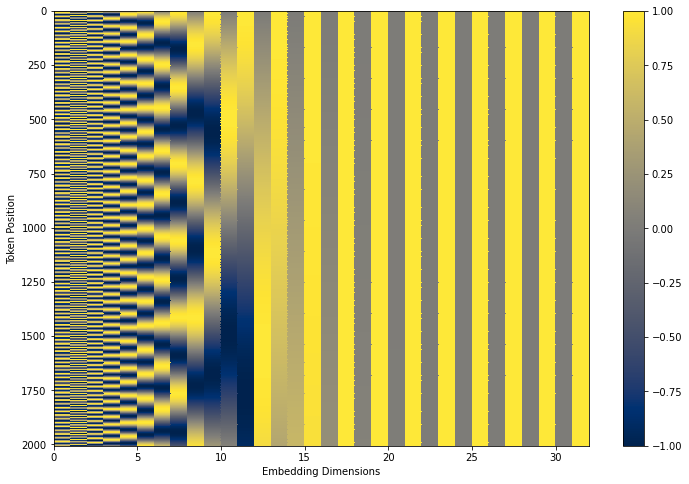

In [17]:
position_to_positional_encoding_mapping = model.generate_position_to_positional_encoding_mapping()
plt.figure(figsize=(12,8))
plt.pcolormesh(position_to_positional_encoding_mapping, cmap='cividis')
plt.xlabel('Embedding Dimensions')
plt.xlim((0, embedding_dimension_size))
plt.ylim((longest_sequence_length,0))
plt.ylabel('Token Position')
plt.colorbar()
plt.show()

In [18]:
batch_size = data_encoded.shape[0]
embedding_dimension_size = 32
position_matrix = model.generate_position_matrix(batch_size)

In [22]:
position_matrix[0][95]

tensor(1)

In [15]:
torch.set_printoptions(profile="full")
print(position_matrix[0])
torch.set_printoptions(profile="default")

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,
        14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0, 

In [19]:
full_sequence_length = data_encoded.shape[1]
batch_size = data_encoded.shape[0]
positional_encodings = position_to_positional_encoding_mapping[position_matrix.view(-1)].view(batch_size, full_sequence_length, embedding_dimension_size)
positional_encodings[0,95]

tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.])

In [47]:
positional_encodings.shape

torch.Size([2277, 2101, 32])

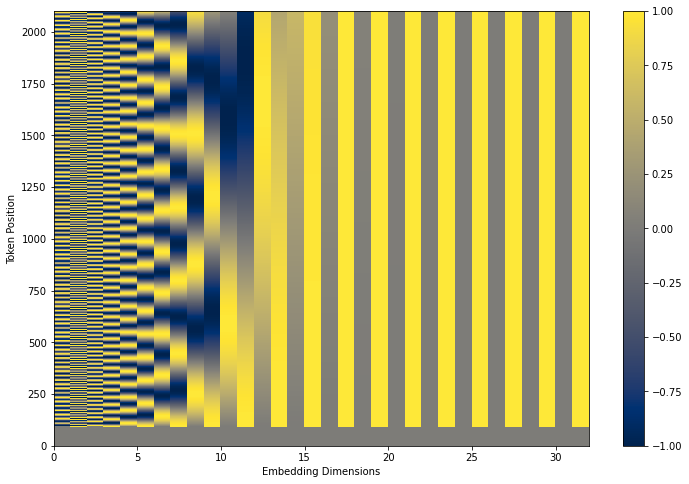

In [48]:
plt.figure(figsize=(12,8))
plt.pcolormesh(positional_encodings[743], cmap='cividis')
plt.xlabel('Embedding Dimensions')
plt.xlim((0, embedding_dimension_size))
plt.ylim((0, full_sequence_length))
plt.ylabel('Token Position')
plt.colorbar()
plt.show()

In [26]:
position_matrix.shape[1]

2101

In [38]:
positional_encodings = torch.Tensor([ [pos / np.power(10000, 2 * embedding_dimension_index/5) for embedding_dimension_index in range(5)] for pos in range(10) ])


tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 2.5119e-02, 6.3096e-04, 1.5849e-05, 3.9811e-07],
        [2.0000e+00, 5.0238e-02, 1.2619e-03, 3.1698e-05, 7.9621e-07],
        [3.0000e+00, 7.5357e-02, 1.8929e-03, 4.7547e-05, 1.1943e-06],
        [4.0000e+00, 1.0048e-01, 2.5238e-03, 6.3396e-05, 1.5924e-06],
        [5.0000e+00, 1.2559e-01, 3.1548e-03, 7.9245e-05, 1.9905e-06],
        [6.0000e+00, 1.5071e-01, 3.7857e-03, 9.5094e-05, 2.3886e-06],
        [7.0000e+00, 1.7583e-01, 4.4167e-03, 1.1094e-04, 2.7868e-06],
        [8.0000e+00, 2.0095e-01, 5.0477e-03, 1.2679e-04, 3.1849e-06],
        [9.0000e+00, 2.2607e-01, 5.6786e-03, 1.4264e-04, 3.5830e-06]])

In [52]:
torch.sin(torch.deg2rad(torch.Tensor([6.3096e-04])))

tensor([1.1012e-05])

In [47]:
import math
math.sin(math.radians(6.3096e-04))

1.1012329448160842e-05

In [40]:
torch.sin(positional_encodings[:, 0::2])

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 8.4147e-01,  6.3096e-04,  3.9811e-07],
        [ 9.0930e-01,  1.2619e-03,  7.9621e-07],
        [ 1.4112e-01,  1.8929e-03,  1.1943e-06],
        [-7.5680e-01,  2.5238e-03,  1.5924e-06],
        [-9.5892e-01,  3.1548e-03,  1.9905e-06],
        [-2.7942e-01,  3.7857e-03,  2.3886e-06],
        [ 6.5699e-01,  4.4167e-03,  2.7868e-06],
        [ 9.8936e-01,  5.0476e-03,  3.1849e-06],
        [ 4.1212e-01,  5.6786e-03,  3.5830e-06]])

In [39]:
positional_encodings[:, 0::2]

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 6.3096e-04, 3.9811e-07],
        [2.0000e+00, 1.2619e-03, 7.9621e-07],
        [3.0000e+00, 1.8929e-03, 1.1943e-06],
        [4.0000e+00, 2.5238e-03, 1.5924e-06],
        [5.0000e+00, 3.1548e-03, 1.9905e-06],
        [6.0000e+00, 3.7857e-03, 2.3886e-06],
        [7.0000e+00, 4.4167e-03, 2.7868e-06],
        [8.0000e+00, 5.0477e-03, 3.1849e-06],
        [9.0000e+00, 5.6786e-03, 3.5830e-06]])

In [36]:
positional_encodings[:, 0::2] = np.sin(positional_encodings[:, 0::2])
positional_encodings

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 8.4147e-01,  2.5119e-02,  6.3096e-04,  1.5849e-05,  3.9811e-07],
        [ 9.0930e-01,  5.0238e-02,  1.2619e-03,  3.1698e-05,  7.9621e-07],
        [ 1.4112e-01,  7.5357e-02,  1.8929e-03,  4.7547e-05,  1.1943e-06],
        [-7.5680e-01,  1.0048e-01,  2.5238e-03,  6.3396e-05,  1.5924e-06],
        [-9.5892e-01,  1.2559e-01,  3.1548e-03,  7.9245e-05,  1.9905e-06],
        [-2.7942e-01,  1.5071e-01,  3.7857e-03,  9.5094e-05,  2.3886e-06],
        [ 6.5699e-01,  1.7583e-01,  4.4167e-03,  1.1094e-04,  2.7868e-06],
        [ 9.8936e-01,  2.0095e-01,  5.0476e-03,  1.2679e-04,  3.1849e-06],
        [ 4.1212e-01,  2.2607e-01,  5.6786e-03,  1.4264e-04,  3.5830e-06]])

In [18]:
abe = [1,2,3,4,5,6]
abe[1::2]

[2, 4, 6]

In [12]:
positional_encodings

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.00000000e+00, 2.51188643e-02, 6.30957344e-04, 1.58489319e-05,
        3.98107171e-07],
       [2.00000000e+00, 5.02377286e-02, 1.26191469e-03, 3.16978638e-05,
        7.96214341e-07],
       [3.00000000e+00, 7.53565929e-02, 1.89287203e-03, 4.75467958e-05,
        1.19432151e-06],
       [4.00000000e+00, 1.00475457e-01, 2.52382938e-03, 6.33957277e-05,
        1.59242868e-06],
       [5.00000000e+00, 1.25594322e-01, 3.15478672e-03, 7.92446596e-05,
        1.99053585e-06],
       [6.00000000e+00, 1.50713186e-01, 3.78574407e-03, 9.50935915e-05,
        2.38864302e-06],
       [7.00000000e+00, 1.75832050e-01, 4.41670141e-03, 1.10942523e-04,
        2.78675019e-06],
       [8.00000000e+00, 2.00950915e-01, 5.04765876e-03, 1.26791455e-04,
        3.18485736e-06],
       [9.00000000e+00, 2.26069779e-01, 5.67861610e-03, 1.42640387e-04,
        3.58296453e-06]])

In [14]:
positional_encodings = np.array([
        [pos / np.power(10000, 2 * embedding_dimension_index/5) for embedding_dimension_index in range(5)]
        if pos != 0 else np.zeros(5) # Why this?
        for pos in range(10)
        ])

In [15]:
positional_encodings

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.00000000e+00, 2.51188643e-02, 6.30957344e-04, 1.58489319e-05,
        3.98107171e-07],
       [2.00000000e+00, 5.02377286e-02, 1.26191469e-03, 3.16978638e-05,
        7.96214341e-07],
       [3.00000000e+00, 7.53565929e-02, 1.89287203e-03, 4.75467958e-05,
        1.19432151e-06],
       [4.00000000e+00, 1.00475457e-01, 2.52382938e-03, 6.33957277e-05,
        1.59242868e-06],
       [5.00000000e+00, 1.25594322e-01, 3.15478672e-03, 7.92446596e-05,
        1.99053585e-06],
       [6.00000000e+00, 1.50713186e-01, 3.78574407e-03, 9.50935915e-05,
        2.38864302e-06],
       [7.00000000e+00, 1.75832050e-01, 4.41670141e-03, 1.10942523e-04,
        2.78675019e-06],
       [8.00000000e+00, 2.00950915e-01, 5.04765876e-03, 1.26791455e-04,
        3.18485736e-06],
       [9.00000000e+00, 2.26069779e-01, 5.67861610e-03, 1.42640387e-04,
        3.58296453e-06]])

In [9]:
positional_encodings[1:, 0::2] = np.sin(positional_encodings[1:, 0::2])

In [10]:
positional_encodings

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 8.41470985e-01,  2.51188643e-02,  6.30957303e-04,
         1.58489319e-05,  3.98107171e-07],
       [ 9.09297427e-01,  5.02377286e-02,  1.26191435e-03,
         3.16978638e-05,  7.96214341e-07],
       [ 1.41120008e-01,  7.53565929e-02,  1.89287090e-03,
         4.75467958e-05,  1.19432151e-06],
       [-7.56802495e-01,  1.00475457e-01,  2.52382670e-03,
         6.33957277e-05,  1.59242868e-06],
       [-9.58924275e-01,  1.25594322e-01,  3.15478149e-03,
         7.92446596e-05,  1.99053585e-06],
       [-2.79415498e-01,  1.50713186e-01,  3.78573502e-03,
         9.50935915e-05,  2.38864302e-06],
       [ 6.56986599e-01,  1.75832050e-01,  4.41668705e-03,
         1.10942523e-04,  2.78675019e-06],
       [ 9.89358247e-01,  2.00950915e-01,  5.04763732e-03,
         1.26791455e-04,  3.18485736e-06],
       [ 4.12118485e-01,  2.26069779e-01,  5.67858558e-03,
         1.42640387e-04

In [33]:
input = torch.arange(0,5).unsqueeze(1).repeat(1,9)
input

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4, 4, 4, 4, 4]])

In [35]:
embedding = nn.Embedding(10, 3, padding_idx=0)
embedding(input)

tensor([[[ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]],

        [[-1.7899, -0.9797,  0.9091],
         [-1.7899, -0.9797,  0.9091],
         [-1.7899, -0.9797,  0.9091],
         [-1.7899, -0.9797,  0.9091],
         [-1.7899, -0.9797,  0.9091],
         [-1.7899, -0.9797,  0.9091],
         [-1.7899, -0.9797,  0.9091],
         [-1.7899, -0.9797,  0.9091],
         [-1.7899, -0.9797,  0.9091]],

        [[-0.0541, -0.2001,  1.7041],
         [-0.0541, -0.2001,  1.7041],
         [-0.0541, -0.2001,  1.7041],
         [-0.0541, -0.2001,  1.7041],
         [-0.0541, -0.2001,  1.7041],
         [-0.0541, -0.2001,  1.7041],
         [-0.0541, -0.2001,  1.7041],
         [-0.0541, -0.2001,  1.7041],
        

In [32]:
torch.LongTensor([[1,2,4,5],[4,3,2,9]])

tensor([[1, 2, 4, 5],
        [4, 3, 2, 9]])

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [18]:
file = "dataset.csv"

data, vocab, longest_sequence_length, sequence_pre_amino_acids_length = get_data(file)
data_encoded, token_to_id, id_to_token = process_data(data, vocab, longest_sequence_length)

In [21]:
data_encoded.shape

(2277, 2101)

In [20]:
data.shape

(2277, 96)

In [ ]:
vocab_size = len(vocab)
embedding_dimension_size = 32
feedforward_dimension_size = 16
longest_sequence_length = 120 # Why is this set to 120?
attention_heads_count = 4
n_layer= 8
model = ProGen(embedding_dimension_size, vocab_size, attention_heads_count, n_layer, feedforward_dimension_size, longest_sequence_length)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 161,122 trainable parameters


In [ ]:
data_encode=torch.from_numpy(data_encoded)
inputs  = torch.zeros(data_encode.shape[0], max_len).to(torch.long).to(device)
targets = torch.zeros(data_encode.shape[0], max_len).to(torch.long).to(device)
for i in range(len(data_encode)):
  inputs[i,  0:len(data_encode[i])]   = data_encode[i].to(device)
  targets[i, 0:len(data_encode[i])-1] = data_encode[i][1:].to(device)
  targets[i, len(data_encode[i])-1]   = 1  # <EOS> token
# Split into train and test dataset
combined = torch.stack([inputs, targets], dim=1)
train_size = int(0.8 * len(combined))
test_size = len(combined) - train_size
train_ds, test_ds = torch.utils.data.random_split(combined, [train_size, test_size])
train_x, train_y = combined[train_ds.indices][:, 0, :], combined[train_ds.indices][:, 1, :]
test_x, test_y   = combined[test_ds.indices][:, 0, :],  combined[test_ds.indices][:, 1, :]
tags_end = data.columns.get_loc("Sequence")

In [ ]:
stats = { 'epoch':[], 'train_loss': [], 'train_perplexity': [], 'test_loss': [], 'test_perplexity': [] }
batch_size, epochs, clip = 16, 500, 50
posem = []
opt = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
criterion = torch.nn.CrossEntropyLoss()
for i in range(epochs):
    model.train()
    opt.zero_grad()
    # Sample a random batch of size `batch_size` from the train dataset
    #idxs = torch.randint(size=(batch_size,), low=0, high=len(train_x))
    idxs = np.random.randint(0, len(train_x), size=(batch_size,))
    output, temp_pos_emb, before_posemb  = model(train_x[idxs])
    loss = criterion(output.view(-1, vocab_size), train_y[idxs].view(-1)) 
    posem.append(_)
    nn.utils.clip_grad_norm_(model.parameters(), 1)
    loss.backward()
    opt.step()
    model.eval()
    idxs = np.random.randint(0, len(test_x), size=(batch_size,))
    output_test,b,c = model(test_x[idxs])
    loss_on_test = criterion(output_test.view(-1, vocab_size), test_y[idxs].view(-1))
    perplexity = torch.exp(loss_on_test).item()
    # Update the stats and print something.
    stats['train_loss'].append(loss.item())
    stats['test_loss'].append(loss_on_test.item())
    stats['epoch'].append(i)
    stats['test_perplexity'].append(perplexity)
    if i % 10 == 0:
      print(i, loss.item())

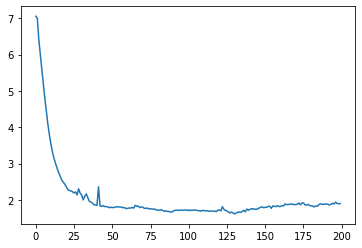

In [ ]:
import matplotlib.pyplot as plt
plt.plot(stats['epoch'], stats['train_loss'])
plt.show()

In [ ]:
test_x[1,50:]

tensor([  2,   2,   2,   2,   2,   2,   2,   2,   2,   2, 492, 426, 426, 832,
        607, 671, 144, 174, 933, 426, 607, 426,  84, 607, 426, 607,  45, 426,
        607, 426,  45, 607, 164, 933, 607,  84,  40,  84, 806, 144, 144, 671,
        144, 551, 956, 144, 164, 551,  40,  84, 144, 144, 551, 551, 607,  84,
        671, 806, 806, 933,  84, 607, 100,  28, 806, 832, 956, 607, 832, 933,
        100, 475, 100, 806, 164, 671, 100, 901,  84, 475, 551,  40, 426, 426,
         84, 551, 607, 607, 572, 164, 164,  40, 956, 956, 100,  40, 475, 100,
        901, 100, 806,  40,  40, 901, 806, 492, 174,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0])